# Monte Carlo Methods

In [1]:
import numpy
import gym
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial

## Blackjack Environment

In [2]:
env = gym.make('Blackjack-v0')
print(env.__doc__)

Simple blackjack environment

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.

    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).

    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.

    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.

    The observation of a 3-tuple of: the players c

In [3]:
env.action_space, env.observation_space

(Discrete(2), Tuple(Discrete(32), Discrete(11), Discrete(2)))

In [4]:
def custom_policy(observation):
    return 0 if observation[0] in [20, 21] else 1

In [5]:
def generate_episode(policy, env):
    states, actions, rewards = [], [], []
    observation = env.reset()
    while True:
        states.append(observation)
        action = policy(observation)
        actions.append(action)
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
            break

    return states, actions, rewards

generate_episode(custom_policy, env)

([(13, 5, False), (14, 5, False)], [1, 1], [0, -1])

## First-visit Monte Carlo Prediction

In [6]:
def monte_carlo_prediction(policy, env, n_episodes):
    V = defaultdict(float)
    N = defaultdict(int)

    for _ in range(n_episodes):
        states, _, rewards = generate_episode(policy, env)
        G = 0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            G += R
            if S not in states[:t]:
                N[S] += 1
                V[S] += (G - V[S]) / N[S]
    return V

V = monte_carlo_prediction(custom_policy, env, n_episodes=10000)
V_ = monte_carlo_prediction(custom_policy, env, n_episodes=500000)

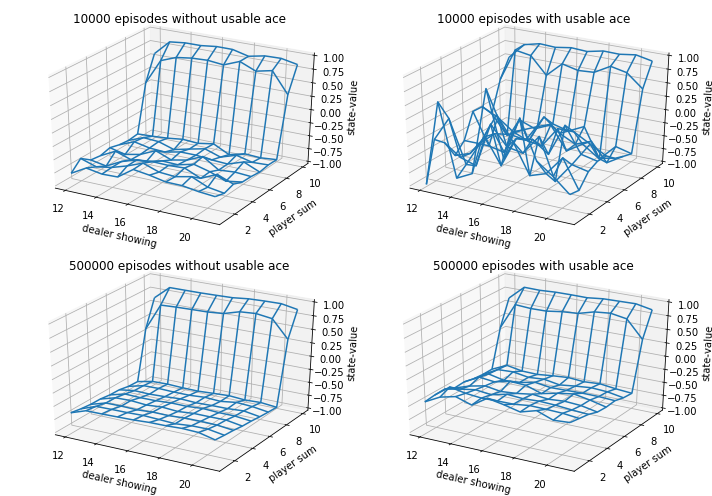

In [7]:
def plot_blackjack(V, ax1, ax2):
    player_sum = numpy.arange(12, 21 + 1)
    dealer_show = numpy.arange(1, 10 + 1)
    usable_ace = numpy.array([False, True])

    state_values = numpy.zeros((len(player_sum),
                                len(dealer_show),
                                len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]

    X, Y = numpy.meshgrid(player_sum, dealer_show)

    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')

fig, axes = pyplot.subplots(nrows=2, ncols=2, figsize=(10, 7), subplot_kw={'projection': '3d'})

axes[0, 0].set_title('10000 episodes without usable ace')
axes[0, 1].set_title('10000 episodes with usable ace')
plot_blackjack(V, axes[0, 0], axes[0, 1])
axes[1, 0].set_title('500000 episodes without usable ace')
axes[1, 1].set_title('500000 episodes with usable ace')
plot_blackjack(V_, axes[1, 0], axes[1, 1])
fig.tight_layout()

## On-policy First-visit Monte Carlo Control

In [8]:
def epsilon_greedy_policy(observation, Q, epsilon):
    if numpy.random.rand() < epsilon:
        return numpy.random.randint(2)
    return 0 if Q[observation, 0] > Q[observation, 1] else 1

In [9]:
def on_policy_monte_carlo_control(env, n_episodes, epsilon=0.1):
    Q = defaultdict(float)
    N = defaultdict(int)
    policy = partial(epsilon_greedy_policy, Q=Q, epsilon=epsilon)

    for _ in range(n_episodes):
        states, actions, rewards = generate_episode(policy, env)
        G = 0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            A = actions[t]
            G += R
            if (S, A) not in zip(states[:t], actions[:t]):
                N[S, A] += 1
                Q[S, A] += (G - Q[S, A]) / N[S, A]
    
    return Q

estimeted_Q = on_policy_monte_carlo_control(env, 500000)

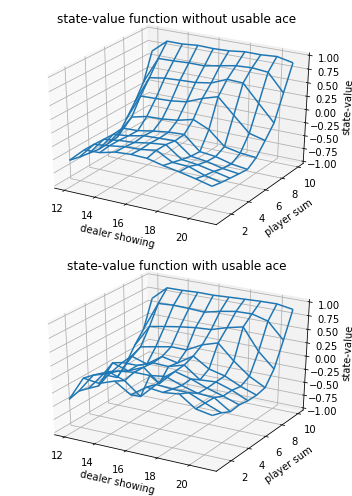

In [10]:
def action_to_state_values(Q):
    V = defaultdict(float)
    for state, action in Q.keys():
        V[state] = max(Q[state, 0], Q[state, 1])
    return V

estimeted_V = action_to_state_values(estimeted_Q)
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 7), subplot_kw={'projection': '3d'})
plot_blackjack(estimeted_V, axes[0], axes[1])
axes[0].set_title('state-value function without usable ace')
axes[1].set_title('state-value function with usable ace')
fig.tight_layout()

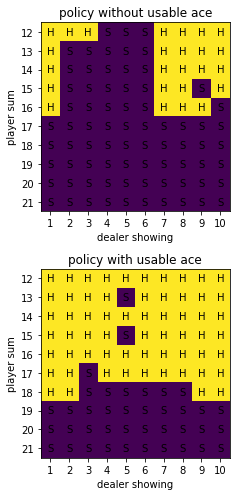

In [13]:
player_sum = numpy.arange(12, 21 + 1)
dealer_show = numpy.arange(1, 10 + 1)
estimated_policy = numpy.zeros((2, len(player_sum), len(dealer_show)), numpy.int)

for i, player in enumerate(player_sum):
    for j, dealer in enumerate(dealer_show):
        for k, ace in enumerate((False, True)):
            S = player, dealer, ace
            estimated_policy[k, i, j] = 0 if estimeted_Q[S, 0] > estimeted_Q[S, 1] else 1

fig, axes = pyplot.subplots(nrows=2, figsize=(7, 7))
axes[0].imshow(estimated_policy[0])
axes[1].imshow(estimated_policy[1])

for ax in axes:
    ax.set_ylabel('player sum')
    ax.set_xlabel('dealer showing')
    ax.set_yticks(numpy.arange(len(player_sum)))
    ax.set_yticklabels(player_sum)
    ax.set_xticks(numpy.arange(len(dealer_show)))
    ax.set_xticklabels(dealer_show)

for i, player in enumerate(player_sum):
    for j, dealer in enumerate(dealer_show):
        for k, ace in enumerate((False, True)):
            axes[k].annotate('H' if estimated_policy[k, i, j] else 'S',
                             xy=(j, i), 
                             horizontalalignment='center',
                             verticalalignment='center')

axes[0].set_title('policy without usable ace')
axes[1].set_title('policy with usable ace')
fig.tight_layout()

## Off-policy Prediction via Importance Sampling

In [14]:
def random_policy(observation):
    # TODO use env.action_space.sample()
    return numpy.random.randint(2)

In [15]:
def off_policy_monte_carlo_control(env, n_episodes, behavior, gamma=1.0):
    Q = defaultdict(float)
    C = defaultdict(int)

    for _ in range(n_episodes):
        states, actions, rewards = generate_episode(behavior, env)
        G = 0
        W = 1
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            A = actions[t]
            G = gamma * G + R
            C[S, A] += W
            Q[S, A] += (W / C[S, A]) * (G - Q[S, A])
            if A != (0 if Q[S, 0] > Q[S, 1] else 1):
                break
            W *= 1 / 2  # TODO
    
    return Q

off_Q = off_policy_monte_carlo_control(env, 500000, random_policy)

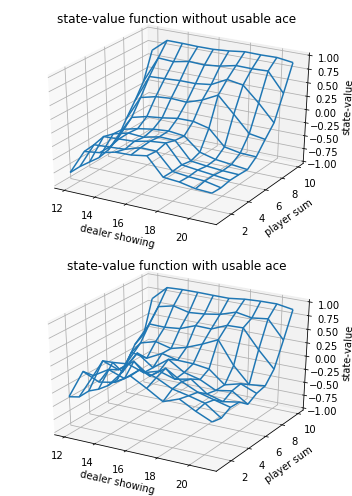

In [16]:
off_V = action_to_state_values(off_Q)
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 7), subplot_kw={'projection': '3d'})
plot_blackjack(off_V, axes[0], axes[1])
axes[0].set_title('state-value function without usable ace')
axes[1].set_title('state-value function with usable ace')
fig.tight_layout()